Some imports and settings

In [20]:
import numpy as np
import time

from PIL import Image
Image.MAX_IMAGE_PIXELS = None # Disable warnings for pillow DecompressionBombError

import matplotlib as mpl
import matplotlib.pyplot as plt

# make the inline image outputs larger
mpl.rcParams['figure.figsize'] = (20,20)

Reading the GeoTIFF as a plain image, not caring about the georeference for now; then convert to numpy array

In [47]:
im = Image.open('popsub.tif')
raster = np.array(im)

# try a mini example
raster=np.array([[0,2],[10,100]])

raster.shape

(2, 2)

Let's take a subset of the 2D array to keep things manageable

In [48]:
# raster = raster[0:300,0:300]
raster.shape

(2, 2)

Plot with matplotlib

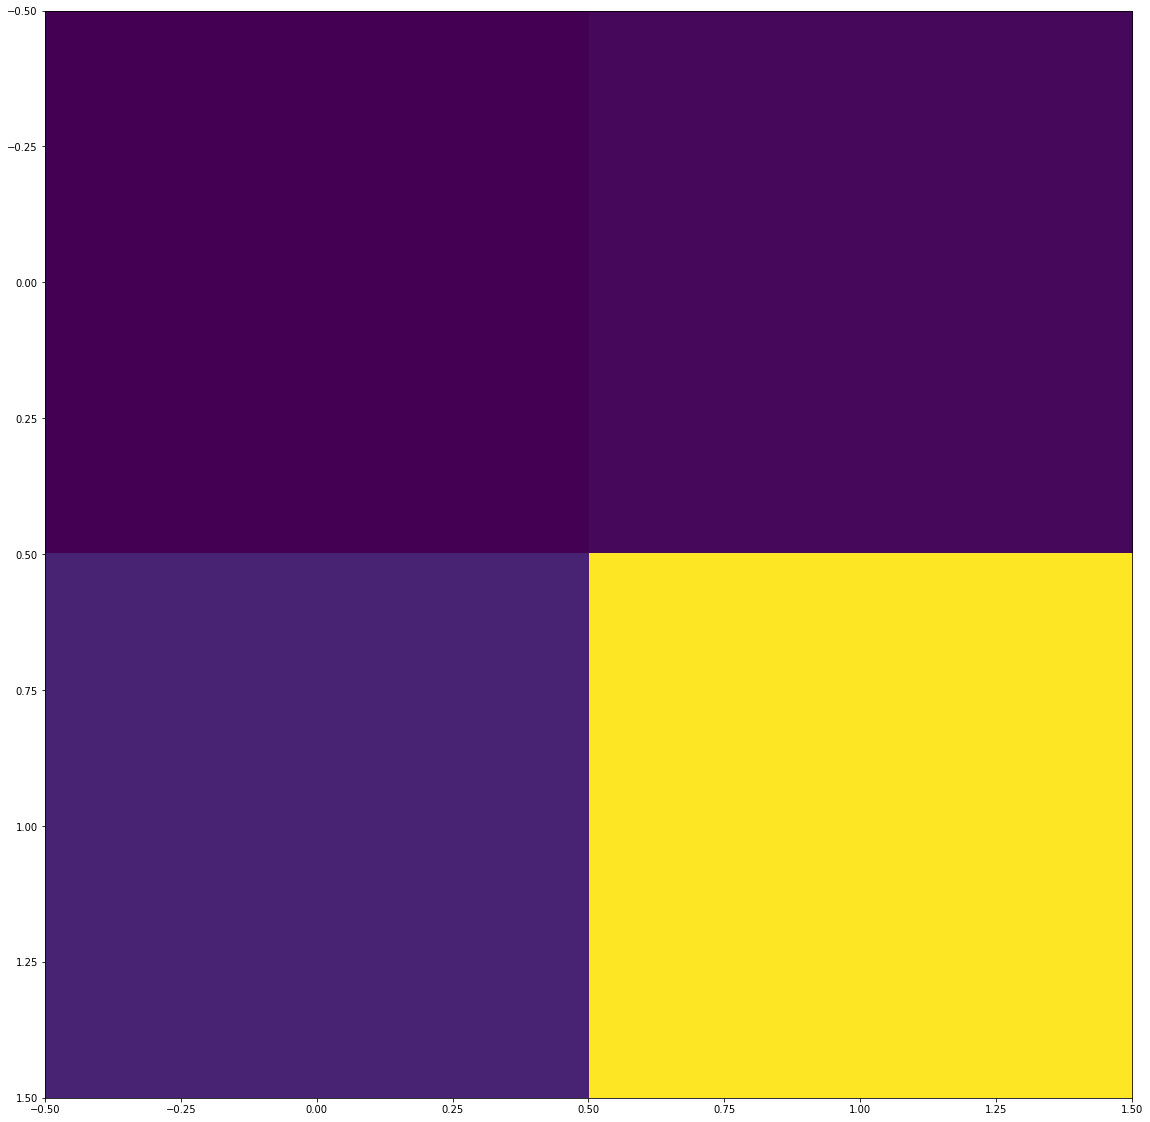

In [49]:
plt.imshow(raster)

In [50]:
numpoints = np.sum(raster)
points = np.zeros((numpoints,2), dtype=int)
points

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0,

Using numpy's [nditer](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.nditer.html#tracking-an-index-or-multi-index) and [append](https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html) - see also the [Minimal Example notebook](Minimal%20Example.ipynb).

In [51]:
# make an empty 2D "target array"
points = np.zeros((numpoints,2), dtype=int)

# keep track of where in the target array we have to insert
insertrow = 0

# iterate over the input raster
it = np.nditer(raster, flags=['multi_index'])
while not it.finished:
    entry = np.array([np.array(it.multi_index)]) # this is the row and column of the current cell
    block = np.repeat(entry, it[0], axis=0) # create one point per "person" in cell
    points[insertrow:insertrow+block.shape[0]] = block # insert the points into the output array
    insertrow = insertrow + block.shape[0] # keep track of where we are in the output array
    it.iternext() # move on 

In [52]:
points

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1,

In [53]:
points.size

224

Next, we will randomly move each point around within its cell. We can also choose to keep the "edges" between the cells (set expansion to < 1.0) or allow the points to go outside the cells, which "softenes" the edges, giving the impression of a more smooth surface (set expansion to > 1.0)

In [54]:
expansion = 1.0

seed = np.random.rand(numpoints,2)
seed = seed * expansion

plot = points + seed

Plot:

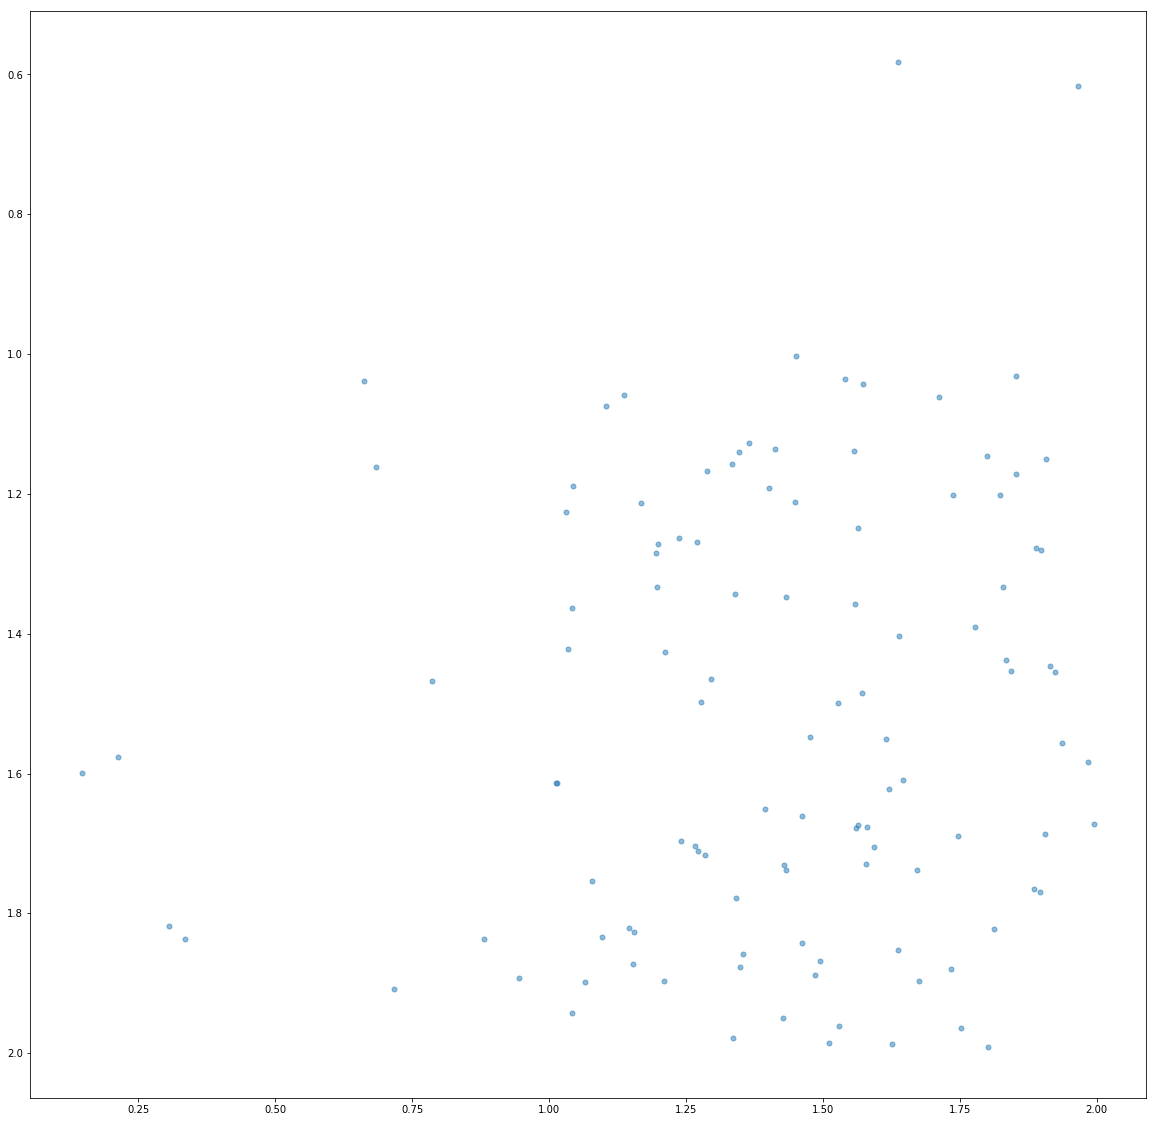

In [55]:
plt.scatter(plot[:,1], plot[:,0], s=100, marker=".", alpha=0.5)
plt.gca().invert_yaxis() # origin top left, as in original image
plt.show()

# not working in the notebook...
# plt.savefig("dots"+str(time.time())+".png", dpi=300)